In [18]:
# Import all modules
import time
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras_sequential_ascii import sequential_model_to_ascii_printout
from keras import backend as K
import tensorflow as tf
import multiprocessing as mp
from keras.datasets import cifar10

from livelossplot import PlotLossesKeras
 
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import MaxPooling2D, AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os 

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
np.random.seed(42)
 
batch_size = 32 
num_classes = 10 
epochs = 25 
img_rows, img_cols = 32, 32

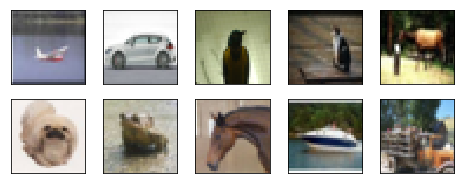

In [4]:
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0]) 
    plt.imshow(features_idx[img_num,::])
plt.show()

In [5]:
y_train = np_utils.to_categorical(y_train, num_classes)
y_test = np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train  /= 255
x_test /= 255

In [6]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [7]:
def base_model():

    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32,(3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    sgd = SGD(lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True)
    # Train model

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

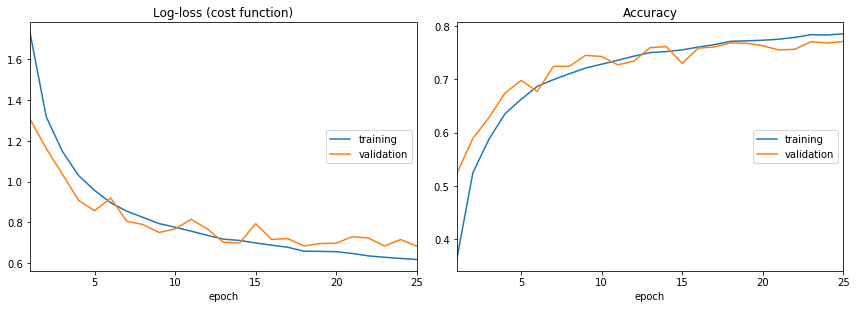

In [8]:
cnn_n = base_model()
cnn_n.summary()

# Fit model 
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test)
                ,shuffle=True, callbacks=[PlotLossesKeras()], verbose=0)

In [9]:
sequential_model_to_ascii_printout(cnn_n)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     32   32    3
              Conv2D    \|/  -------------------       896     0.1%
                relu   #####     32   32   32
              Conv2D    \|/  -------------------      9248     0.7%
                relu   #####     30   30   32
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     15   15   32
             Dropout    | || -------------------         0     0.0%
                       #####     15   15   32
              Conv2D    \|/  -------------------     18496     1.5%
                relu   #####     15   15   64
              Conv2D    \|/  -------------------     36928     3.0%
                relu   #####     13   13   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      6    6   64
             Dropout    | || -------------------         0     0.0%
              

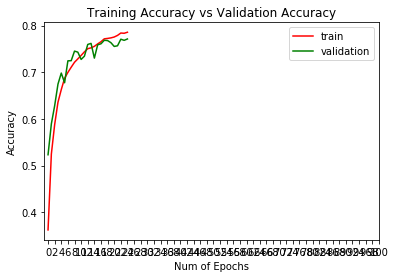

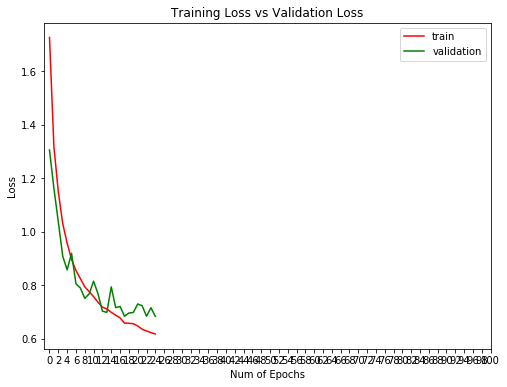

In [10]:
# Plots for training and testing process: loss and accuracy

plt.figure(0)
plt.plot(cnn.history['acc'],'r')
plt.plot(cnn.history['val_acc'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])


plt.figure(1)
plt.plot(cnn.history['loss'],'r')
plt.plot(cnn.history['val_loss'],'g')
plt.xticks(np.arange(0, 101, 2.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])


plt.show()

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[781  12  20  34   8   4  12  14  77  38]
 [ 10 855   4  12   2   1   9   3  29  75]
 [ 79   3 644  93  37  45  53  24  15   7]
 [ 18   0  46 684  34  99  49  42  15  13]
 [ 13   2  65 124 654  25  66  41   9   1]
 [  6   4  34 217  19 651  16  45   5   3]
 [  3   0  41  65  19  14 842   4  11   1]
 [ 10   1  20  52  27  39   9 830   4   8]
 [ 36   8   6  20   2   2   4   4 899  19]
 [ 13  45   2  16   1   2   6   8  35 872]]


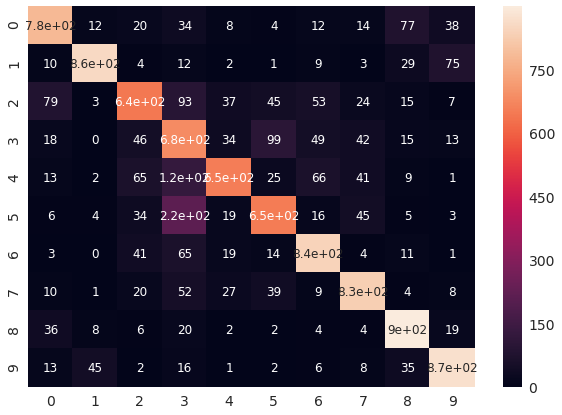

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = cnn_n.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd
 
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()

In [15]:
def base_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(Dropout(0.2))

    model.add(Conv2D(32,(3,3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(Dropout(0.2))

    model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(1024,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    sgd = SGD(lr = 0.01, decay=1e-6, momentum=0.9, nesterov=True)
    # Train model

    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

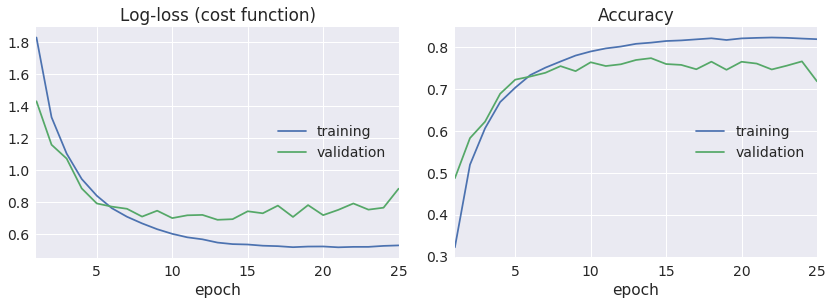

In [16]:
cnn = base_model().fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test)
                ,shuffle=True, callbacks=[PlotLossesKeras()], verbose=0)

## Resnet with Improved Regularization of Convolutional Neural Networks with Cutout 
### SOTA

https://arxiv.org/pdf/1708.04552.pdf

In [23]:
# Training params.
batch_size = 32
epochs = 100
data_augmentation = True
random_erasing = True
pixel_level = False

# Network architecture params.
num_classes = 10
num_filters = 64
num_blocks = 4
num_sub_blocks = 2
use_max_pool = False
(x_train, y_train), (x_test, y_test) = cifar10.load_data()


if K.image_data_format() == 'channels_first':
    img_rows = x_train.shape[2]
    img_cols = x_train.shape[3]
    channels = x_train.shape[1]
    x_train = x_train.reshape(x_train.shape[0], channels, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], channels, img_rows, img_cols)
    input_shape = (channels, img_rows, img_cols)
else:
    img_rows = x_train.shape[1]
    img_cols = x_train.shape[2]
    channels = x_train.shape[3]
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, channels)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, channels)
    input_shape = (img_rows, img_cols, channels)
    
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [24]:
# Start model definition.
inputs = Input(shape=input_shape)
x = Conv2D(num_filters,
           kernel_size=7,
           padding='same',
           strides=2,
           kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4))(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Orig paper uses max pool after 1st conv.
# Reaches up 87% acc if use_max_pool = True.
# Cifar10 images are already too small at 32x32 to be maxpooled. So, we skip.
if use_max_pool:
    x = MaxPooling2D(pool_size=3, strides=2, padding='same')(x)
    num_blocks = 3

# Instantiate convolutional base (stack of blocks).
for i in range(num_blocks):
    for j in range(num_sub_blocks):
        strides = 1
        is_first_layer_but_not_first_block = j == 0 and i > 0
        if is_first_layer_but_not_first_block:
            strides = 2
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   strides=strides,
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(x)
        y = BatchNormalization()(y)
        y = Activation('relu')(y)
        y = Conv2D(num_filters,
                   kernel_size=3,
                   padding='same',
                   kernel_initializer='he_normal',
                   kernel_regularizer=l2(1e-4))(y)
        y = BatchNormalization()(y)
        if is_first_layer_but_not_first_block:
            x = Conv2D(num_filters,
                       kernel_size=1,
                       padding='same',
                       strides=2,
                       kernel_initializer='he_normal',
                       kernel_regularizer=l2(1e-4))(x)
        x = keras.layers.add([x, y])
        x = Activation('relu')(x)

    num_filters = 2 * num_filters
    
# Add classifier on top.
x = AveragePooling2D()(x)
y = Flatten()(x)
outputs = Dense(num_classes,
                activation='softmax',
                kernel_initializer='he_normal')(y)

In [25]:
# Instantiate and compile model.
model = Model(inputs=inputs, outputs=outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 16, 16, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 16, 16, 64)   256         conv2d_17[0][0]                  
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 16, 16, 64)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_18 

In [26]:
# Prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_resnet_model.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

In [28]:
# Prepare callbacks for model saving and for learning rate decaying.
checkpoint = ModelCheckpoint(filepath=filepath,
                             verbose=1,
                             save_best_only=True)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)
callbacks = [checkpoint, lr_reducer, PlotLossesKeras()] 

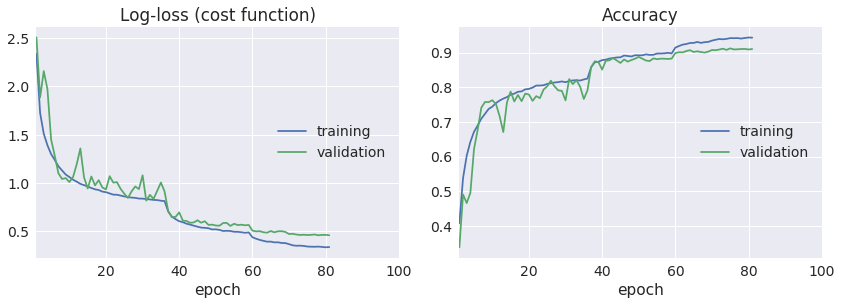

Epoch 82/100
 695/1562 [============>.................] - ETA: 35s - loss: 0.3297 - acc: 0.9444

In [ ]:
# Run training, with or without data augmentation.
if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(x_test, y_test),
              shuffle=True,
              callbacks=callbacks)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and realtime data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=pixel_level))

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, verbose=1, 
                        callbacks=callbacks)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])